Here we train a machine learning model that will help us predict car prices with Machine Learning using **PyTorch**. The dataset I’m going to use here to **predict car prices** is tabular data with the prices of different cars regarding the other variables, the dataset has *258 rows and 9 columns*, the variable we want to predict is the selling price of the cars.

Now, let’s start with the task of machine learning to predict car prices using PyTorch. I will start by importing all the necessary libraries that we need for this task.

In [1]:
import torch
import jovian
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

lets read the data.

In [3]:
DATA_FILENAME = "car data.csv"
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


now lets visualize the data via few plots to gain some insights.

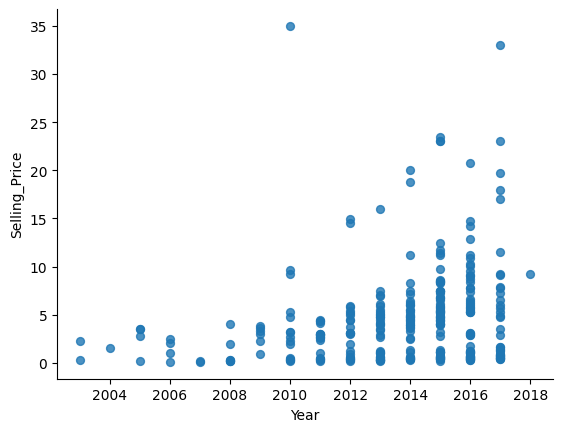

In [24]:
from matplotlib import pyplot as plt
dataframe_raw.plot(kind='scatter', x='Year', y='Selling_Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

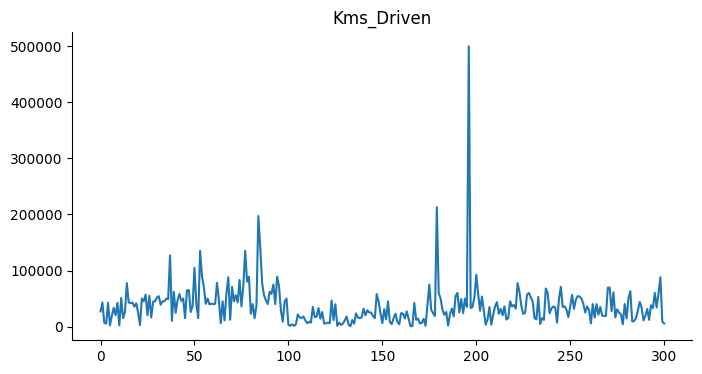

In [22]:
from matplotlib import pyplot as plt
dataframe_raw['Kms_Driven'].plot(kind='line', figsize=(8, 4), title='Kms_Driven')
plt.gca().spines[['top', 'right']].set_visible(False)

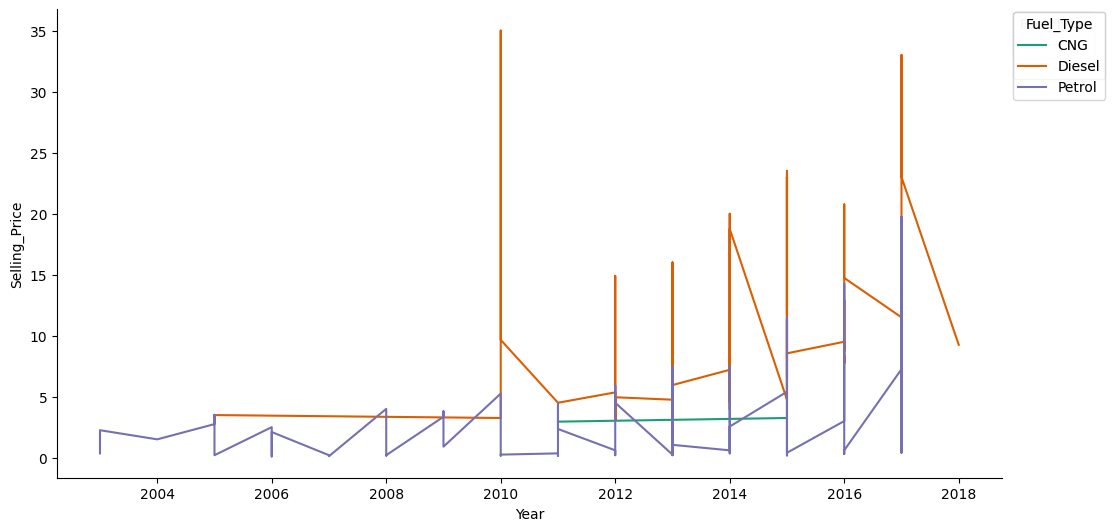

In [20]:

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Selling_Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dataframe_raw.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Fuel_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Fuel_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Selling_Price')

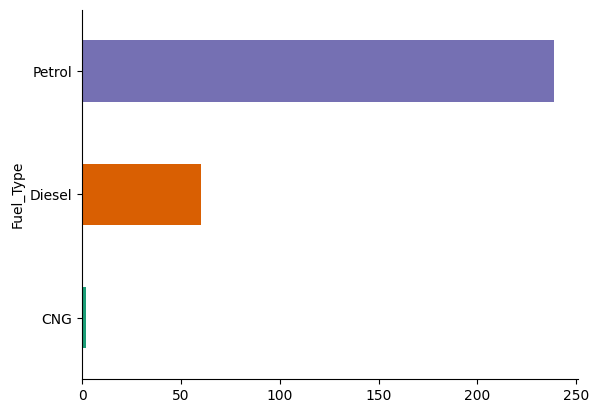

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
dataframe_raw.groupby('Fuel_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

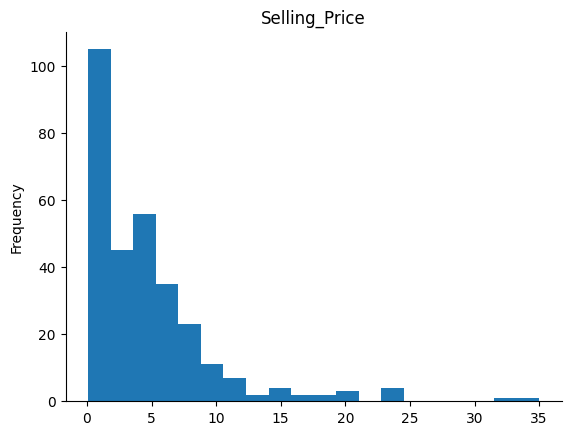

In [18]:
from matplotlib import pyplot as plt
dataframe_raw['Selling_Price'].plot(kind='hist', bins=20, title='Selling_Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

You can see what the data looks like, but before using it we need to customize it, sort the arrows and remove the columns that don’t help the prediction, here we drop the car names, and to do this customization, we use the following function:

In [5]:
your_name = "dinesh" # at least 5 characters
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.Year = dataframe.Year * ord(rand_str[1])/100.
    # scale target
    dataframe.Selling_Price = dataframe.Selling_Price * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['Car_Name'], axis=1)
    return dataframe

dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
199,2107.35,0.132,0.58,53000,Petrol,Individual,Manual,0
201,2110.50,3.575,6.79,58000,Diesel,Dealer,Manual,1
111,2116.80,1.265,1.50,8700,Petrol,Individual,Manual,0
125,2109.45,0.990,1.75,40000,Petrol,Individual,Manual,0
46,2113.65,2.915,4.89,64532,Petrol,Dealer,Manual,0


In [6]:
input_cols = ["Year","Present_Price","Kms_Driven","Owner"]
categorical_cols = ["Fuel_Type","Seller_Type","Transmission"]
output_cols = ["Selling_Price"]

# Data Prep

I will be using PyTorch to predict car prices using machine learning, so to use the data for training we need to convert it from dataframe to PyTorch Tensors, the first step is to convert to NumPy arrays:

In [7]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[2.10735e+03, 5.80000e-01, 5.30000e+04, 0.00000e+00],
        [2.11050e+03, 6.79000e+00, 5.80000e+04, 1.00000e+00],
        [2.11680e+03, 1.50000e+00, 8.70000e+03, 0.00000e+00],
        ...,
        [2.11260e+03, 9.40000e+00, 7.10000e+04, 0.00000e+00],
        [2.11680e+03, 8.00000e-01, 2.00000e+04, 0.00000e+00],
        [2.11785e+03, 5.10000e-01, 4.30000e+03, 0.00000e+00]]),
 array([[ 0.132],
        [ 3.575],
        [ 1.265],
        [ 0.99 ],
        [ 2.915],
        [ 3.85 ],
        [ 6.6  ],
        [ 3.685],
        [ 0.528],
        [ 3.575],
        [ 0.418],
        [ 6.545],
        [ 7.645],
        [ 3.41 ],
        [ 1.595],
        [ 7.15 ],
        [ 2.75 ],
        [ 0.165],
        [10.175],
        [ 1.32 ],
        [ 0.88 ],
        [12.375],
        [ 4.4  ],
        [ 0.44 ],
        [ 7.15 ],
        [ 9.405],
        [ 0.495],
        [ 4.345],
        [ 0.561],
        [ 1.155],
        [ 7.92 ],
        [18.7  ],
        [ 4.95 ],
        [ 8.25 ],
 

In [8]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

dataset = TensorDataset(inputs, targets)
train_ds, val_ds = random_split(dataset, [228, 57])
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# Creating PyTorch Model
Now, I am going to create a linear regressing model using PyTorch to predict car prices:

In [9]:
input_size = len(input_cols)
output_size = len(output_cols)

class CarsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)

    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.l1_loss(out, targets)                         # fill this
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

model = CarsModel()

list(model.parameters())

[Parameter containing:
 tensor([[-0.0071, -0.2540,  0.4749, -0.2963]], requires_grad=True),
 Parameter containing:
 tensor([0.2324], requires_grad=True)]

In this above function, I used the nn.Linear function which will allow us to use linear regression so now we can calculate the predictions and the loss with the F.l1_loss function can see the weight parameter one bias, with this model we will get the predictions, but will still have to undergo training.

In [10]:
# Eval algorithm
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fitting algorithm
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

# Check the initial value that val_loss have
result = evaluate(model, val_loader)
print(result)

{'val_loss': 14614.6767578125}


In [11]:
# Start with the Fitting
epochs = 90
lr = 1e-8
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 14143.8027
Epoch [40], val_loss: 13673.0859
Epoch [60], val_loss: 13203.0342
Epoch [80], val_loss: 12733.7510
Epoch [90], val_loss: 12499.4189


In [12]:
# Train repeatdly until have a 'good' val_loss
epochs = 20
lr = 1e-9
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 12452.3223


# Using the Model to Predict Car Prices
Finally, we need to test the model with specific data, to predict it is necessary to use the input which will be the input values ​​that we see in the dataset, and the model is the Cars model that we do, for the passing in the model is necessary to flatten, so with all this, predict the selling prices:

In [13]:
# Prediction Algorithm
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

# Testing the model with some samples
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([2.1168e+03, 1.5000e+00, 8.7000e+03, 0.0000e+00])
Target: tensor([1.2650])
Prediction: tensor([3500.1829])


In [14]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([2.1105e+03, 6.7900e+00, 5.8000e+04, 1.0000e+00])
Target: tensor([3.5750])
Prediction: tensor([23466.2461])
